In [1]:
!pip install pmdarima


   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
    --------------------------------------- 10.2/625.1 kB ? eta -:--:--
   ----- ---------------------------------- 81.9/625.1 kB 1.2 MB/s eta 0:00:01
   ------------------------------------ --- 563.2/625.1 kB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 625.1/625.1 kB 5.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------- -------------------------- 1.0/2.8 MB 31.1 MB/s eta 0:00:01
   --------------------------- ------------ 1.9/2.8 MB 20.5 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 22.2 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 17.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima


In [3]:
va_filtered_listings = pd.read_csv("va_filtered_listings.csv")

# Display the first few rows
va_filtered_listings.head()

,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,state,...,sold_above_list_yoy,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated
0,5/1/2019,7/31/2019,90,zip code,2,9670,f,Zip Code: 24244,NaN,Virginia,...,0.100000,NaN,NaN,NaN,0.100000,0.000000,0.100000,"Kingsport, TN",28700,2/10/2025 14:21
1,6/1/2022,8/31/2022,90,zip code,2,9223,f,Zip Code: 23235,NaN,Virginia,...,0.037794,NaN,NaN,NaN,0.680272,-0.059373,-0.023216,"Richmond, VA",40060,2/10/2025 14:21
2,9/1/2024,11/30/2024,90,zip code,2,9824,f,Zip Code: 24563,NaN,Virginia,...,-0.716667,NaN,NaN,NaN,0.375000,-0.069444,0.000000,"Danville, VA",19260,2/10/2025 14:21
3,8/1/2018,10/31/2018,90,zip code,2,7894,f,Zip Code: 20187,NaN,Virginia,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,"Washington, DC",47894,2/10/2025 14:21
4,11/1/2022,1/31/2023,90,zip code,2,9224,f,Zip Code: 23236,NaN,Virginia,...,-0.084934,NaN,NaN,NaN,0.452830,-0.032464,-0.188679,"Richmond, VA",40060,2/10/2025 14:21


In [5]:
va_filtered_listings['period_begin'] = pd.to_datetime(va_filtered_listings['period_begin'], errors='coerce')
va_filtered_listings = va_filtered_listings.sort_values('period_begin')
va_filtered_listings.set_index('period_begin', inplace=True)

In [6]:
monthly_sales = va_filtered_listings['median_sale_price'].resample('M').mean()

C:\Users\putna\AppData\Local\Temp\ipykernel_38552\3339429168.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = va_filtered_listings['median_sale_price'].resample('M').mean()


### Fitting the model

In [7]:
auto_model = auto_arima(monthly_sales, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3089.491, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3098.539, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3093.859, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3094.022, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3105.253, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=3087.492, Time=1.12 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=3090.134, Time=0.51 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=3088.992, Time=3.50 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=3087.510, Time=1.05 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=3087.556, Time=3.70 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=3093.810, Time=0.67 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=3093.989, Time=0.56 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=3083.461, Time=1.15 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=3089.640, Time=0.59 sec
 ARIMA(3,1,2)(1,0,1

### Training sarima

In [8]:
sarima_model = SARIMAX(monthly_sales, 
                       order=auto_model.order, 
                       seasonal_order=auto_model.seasonal_order)
sarima_fit = sarima_model.fit()

### Future Prediction

In [9]:
future_forecast = sarima_fit.get_forecast(steps=12)
forecast_index = pd.date_range(start=monthly_sales.index[-1], periods=13, freq='M')[1:]
forecast_series = pd.Series(future_forecast.predicted_mean.values, index=forecast_index)

C:\Users\putna\AppData\Local\Temp\ipykernel_38552\3778780976.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_sales.index[-1], periods=13, freq='M')[1:]


### Plot

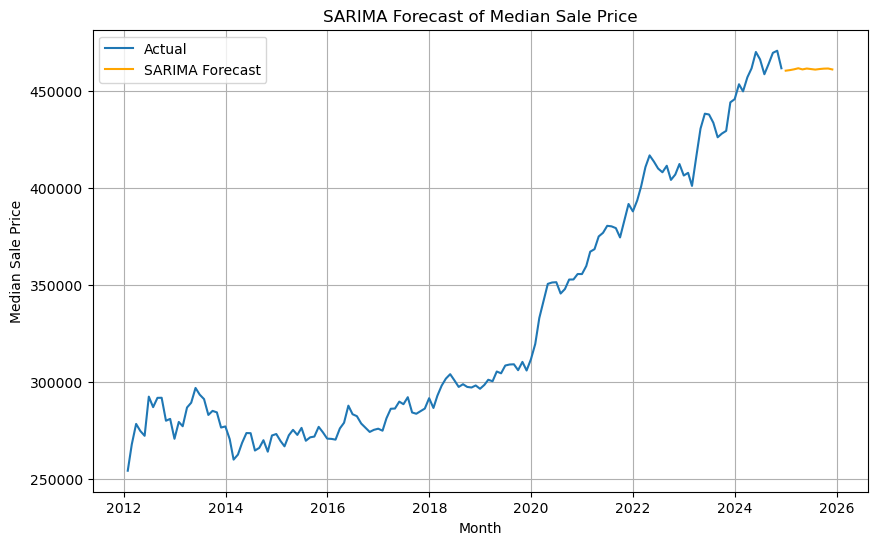

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales, label='Actual')
plt.plot(forecast_series, color='orange', label='SARIMA Forecast')
plt.title('SARIMA Forecast of Median Sale Price')
plt.xlabel('Month')
plt.ylabel('Median Sale Price')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 9. Split data into train and test sets
train_size = int(len(monthly_sales) * 0.8)
train, test = monthly_sales[:train_size], monthly_sales[train_size:]

# 10. Fit the SARIMA model on the training set
sarima_model = SARIMAX(train, 
                       order=auto_model.order, 
                       seasonal_order=auto_model.seasonal_order)
sarima_fit = sarima_model.fit()

# 11. Forecast on the test set
test_forecast = sarima_fit.get_forecast(steps=len(test))
predicted_values = test_forecast.predicted_mean

# 12. Calculate evaluation metrics
mae = mean_absolute_error(test, predicted_values)
rmse = np.sqrt(mean_squared_error(test, predicted_values))
mape = np.mean(np.abs((test - predicted_values) / test)) * 100

print("SARIMA Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


SARIMA Model Performance:
MAE: 22521.81
RMSE: 27398.23
MAPE: 5.02%


#### Model is accurate and stable, with only 5% average error, good for time series forecasting.
#### However, the higher RMSE suggests some outliers or unexpected market shifts, which SARIMA may struggle with. This could be due to COVID market fluctuations or seasonality effects.

### Plot Forecast vs actual

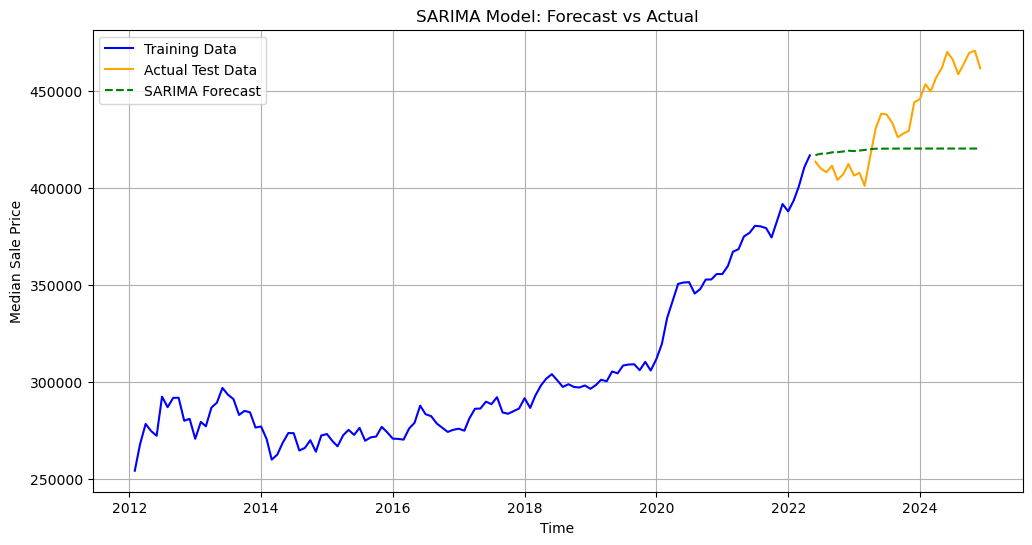

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data', color='blue')
plt.plot(test, label='Actual Test Data', color='orange')
plt.plot(predicted_values, label='SARIMA Forecast', color='green', linestyle='dashed')
plt.title('SARIMA Model: Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Median Sale Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Forecast for the next 12 months
forecast = results.get_forecast(steps=12, exog=test[exog_vars].iloc[-12:])
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10, 5))
plt.plot(va_filtered_listings[target], label='Observed')
plt.plot(forecast.predicted_mean, color='green', label='Forecast')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.title('Future Housing Price Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Extra work

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Target variable and exogenous features
target = 'median_sale_price'
exog_vars = ['inventory', 'new_listings', 'pending_sales', 'price_drops']

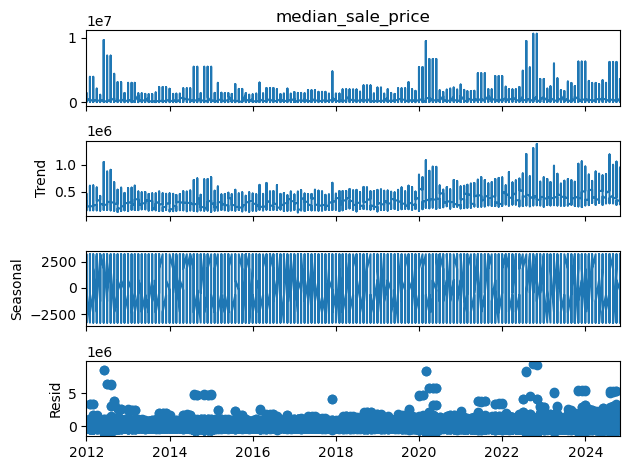

In [16]:
# Seasonal Decomposition
decomposition = seasonal_decompose(va_filtered_listings[target], model='additive', period=12)
decomposition.plot()
plt.show()

In [17]:
# Train-test split
train_size = int(len(va_filtered_listings) * 0.8)
train, test = va_filtered_listings.iloc[:train_size], va_filtered_listings.iloc[train_size:]

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(train[target], label='Training Data')
plt.plot(test[target], label='Actual Data', color='blue')
plt.plot(predictions, label='Predicted', color='orange')
plt.title('SARIMAX Model: Median Sale Price Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(train[target], label='Training Data')
plt.plot(test[target], label='Actual Data', color='blue')
plt.plot(predictions, label='Predicted', color='orange')
plt.title('SARIMAX Model: Median Sale Price Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Fit SARIMAX Model
model = SARIMAX(train[target], exog=train[exog_vars], 
                order=stepwise_model.order, 
                seasonal_order=stepwise_model.seasonal_order)
results = model.fit()

In [ ]:
# Predict on test set
predictions = results.predict(start=test.index[0], end=test.index[-1], exog=test[exog_vars])

In [ ]:
# Model evaluation
mae = mean_absolute_error(test[target], predictions)
rmse = np.sqrt(mean_squared_error(test[target], predictions))
mape = np.mean(np.abs((test[target] - predictions) / test[target])) * 100

print("SARIMAX Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(train[target], label='Training Data')
plt.plot(test[target], label='Actual Data', color='blue')
plt.plot(predictions, label='Predicted', color='orange')
plt.title('SARIMAX Model: Median Sale Price Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Forecast for the next 12 months
forecast = results.get_forecast(steps=12, exog=test[exog_vars].iloc[-12:])
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10, 5))
plt.plot(va_filtered_listings[target], label='Observed')
plt.plot(forecast.predicted_mean, color='green', label='Forecast')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.title('Future Housing Price Forecast')
plt.legend()
plt.grid(True)
plt.show()
